# Coffee data - Bewertungen und Zusammenhänge untersuchen

**Projektschritt 3:** 
Gibt es Zusammenhänge zwischen demografischen Merkmalen und/oder Konsummustern und der bevorzugten Kaffeesorte?  
-> Erstellung eines interaktiven Dashboards mit plotly/dash 

## Module und Daten laden

In [1]:
# Import modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from dash import Dash, html, dcc, callback, Output, Input
from dash.exceptions import PreventUpdate

## Daten vorbereiten

In [2]:
# Read prepared data
descriptives = pd.read_pickle("coffee_data_descriptives.pkl")
ratings = pd.read_pickle("coffee_data_ratings.pkl")
df = pd.merge(descriptives, ratings, on="submission_id", how="outer")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 34 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   submission_id                                     4042 non-null   category
 1   age                                               4042 non-null   category
 2   gender                                            4042 non-null   category
 3   expertise                                         4042 non-null   category
 4   strength                                          4042 non-null   category
 5   roast_level                                       4042 non-null   category
 6   style                                             4042 non-null   category
 7   favorite                                          4042 non-null   category
 8   brew Bean-to-cup machine                          4042 non-null   bool    
 9   brew Cof

In [3]:
df["gender"] = df["gender"].replace({"Prefer not to say": "keine Angabe",
                                     "Male": "männlich",
                                     "Female": "weiblich",
                                     "Non-binary": "nicht-binär",
                                     "Other (please specify)": "andere"})
df["age"] = df["age"].str.replace("years old", "Jahre alt").astype("category")
age_order = ['<18 Jahre alt', '18-24 Jahre alt', '25-34 Jahre alt', '35-44 Jahre alt', '45-54 Jahre alt', '55-64 Jahre alt', '>65 Jahre alt', 'keine Angabe']
df["age"] = df["age"].cat.set_categories(age_order, 
                                         ordered=True)


C:\Users\alfa\AppData\Local\Temp\ipykernel_4720\3464599961.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["gender"] = df["gender"].replace({"Prefer not to say": "keine Angabe",


In [4]:
# Daten filtern: keine Angabe raus, Kategorien <5% raus

df_clean = df[df["prefer_overall"] != "keine Angabe"]
df_clean["prefer_overall"] = df_clean["prefer_overall"].cat.remove_unused_categories()

cols = ["age", "gender", "roast_level", "strength", "style", "favorite"]
#expertise ganz drin lassen?

for col in cols: 
    n_5 = pd.DataFrame(df_clean[col].value_counts(normalize=True)).reset_index()
    n_5 = n_5[n_5["proportion"]<=0.05][col]
    df_clean = df_clean[~df_clean[col].isin(n_5)].copy()
    df_clean[col] = df_clean[col].cat.remove_unused_categories()
    print(df_clean[col].value_counts())

age
25-34 Jahre alt    1890
35-44 Jahre alt     902
18-24 Jahre alt     416
45-54 Jahre alt     281
Name: count, dtype: int64
gender
männlich        2370
weiblich         768
keine Angabe     239
Name: count, dtype: int64
roast_level
Light     1584
Medium    1311
Dark       313
Name: count, dtype: int64
strength
Somewhat strong    1486
Medium             1162
Very strong         346
Somewhat light      162
Name: count, dtype: int64
style
Fruity         804
Chocolatey     502
Full Bodied    342
Bright         289
Nutty          241
Caramalized    232
Juicy          226
Sweet          226
Name: count, dtype: int64
favorite
Pourover               802
Latte                  498
Regular drip coffee    284
Cappuccino             250
Cortado                241
Espresso               222
Americano              187
Name: count, dtype: int64


C:\Users\alfa\AppData\Local\Temp\ipykernel_4720\1026197742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["prefer_overall"] = df_clean["prefer_overall"].cat.remove_unused_categories()


In [5]:
df_clean["expertise"] = df_clean["expertise"].cat.as_ordered()

## Zusammenhang demografische Variablen mit Kaffeepräferenz

In [6]:
# Eigenschaften für Plots definieren
coffee_order = ["Coffee A", "Coffee B", "Coffee C", "Coffee D", "keine Angabe"]
c_map = {
    "Coffee A": "#d2b48c",
    "Coffee D": "#d2b48c",
    "Coffee B": "#a0522d",
    "Coffee C": "#5c3317",
    "keine Angabe": "#d3d3d3"
}

p_map = {
    "Coffee A": "",
    "Coffee D": "/",
    "Coffee B": "",
    "Coffee C": "",
    "keine Angabe": ""
}

### Alter

In [7]:
# Werte zählen für Plot
df_cat = pd.DataFrame(df.groupby(by="age", observed=False)["prefer_overall"].value_counts(normalize=True)).reset_index()
df_cat["proportion"] = df_cat["proportion"]*100
df_cat = df_cat[df_cat["age"] != "keine Angabe"]

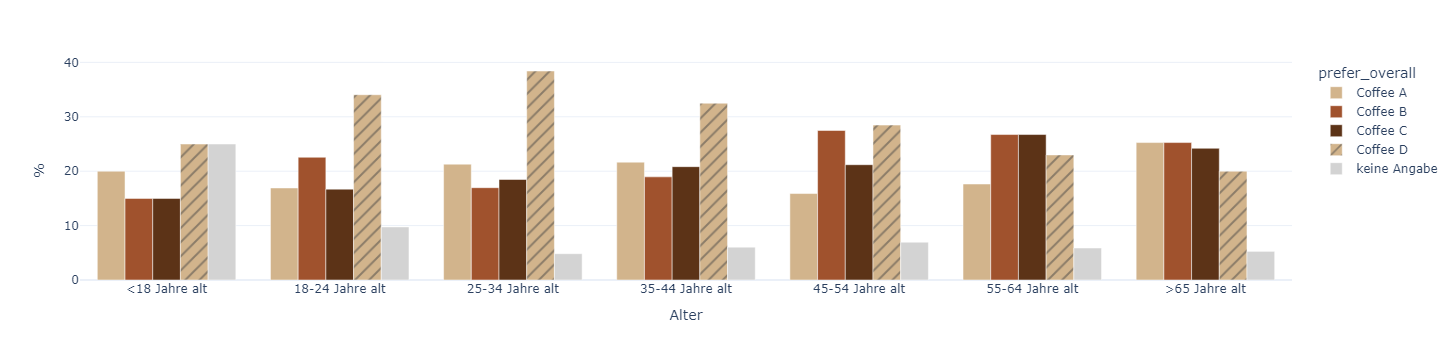

In [8]:
# Plot

fig = px.bar(df_cat, y="proportion", x="age", color="prefer_overall", 
             pattern_shape="prefer_overall",
             color_discrete_map=c_map,
             pattern_shape_map=p_map,
             template="plotly_white",
             barmode="group",
             category_orders={"prefer_overall": coffee_order})
fig.update_layout(xaxis_title="Alter", yaxis_title="%")

Kaffee D ist vor allem bei Leuten bis 44 Jahre beliebt, bei älteren eher dunklere Röstungen wie Kaffee B und C. 


### Geschlecht

In [9]:
# Werte zählen für Plot
df_cat = pd.DataFrame(df.groupby(by="gender", observed=False)["prefer_overall"].value_counts(normalize=True)).reset_index()
df_cat["proportion"] = df_cat["proportion"]*100
df_cat = df_cat[df_cat["gender"] != "keine Angabe"]

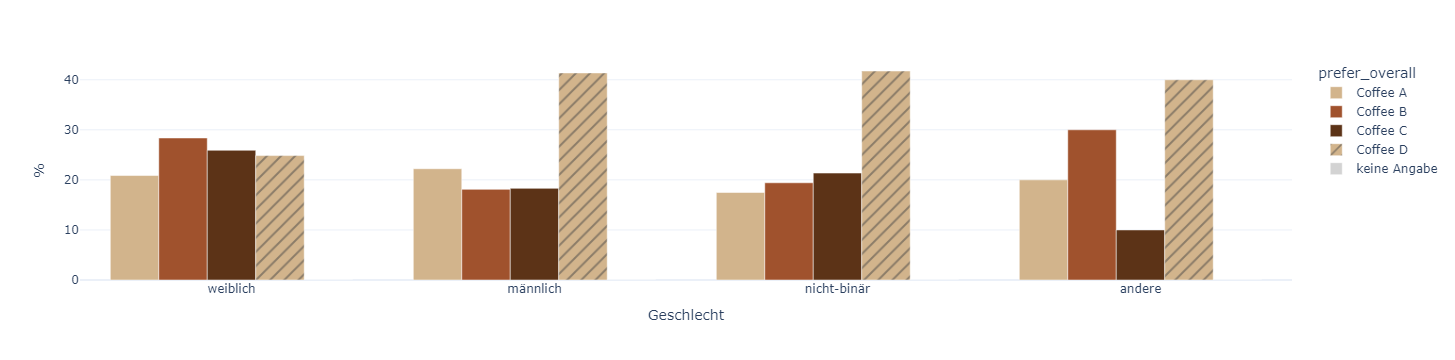

In [10]:
# Plot

fig = px.bar(df_cat, y="proportion", x="gender", color="prefer_overall", 
             pattern_shape="prefer_overall",
             color_discrete_map=c_map,
             pattern_shape_map=p_map,
             template="plotly_white",
             barmode="group",
             category_orders={"prefer_overall": coffee_order})
fig.update_layout(xaxis_title="Geschlecht", yaxis_title="%")

In [11]:
print(df["age"].value_counts(normalize=True))
print(df["gender"].value_counts(normalize=True))

age
25-34 Jahre alt    0.491341
35-44 Jahre alt    0.237506
18-24 Jahre alt    0.114052
45-54 Jahre alt    0.074715
55-64 Jahre alt    0.046264
>65 Jahre alt      0.023503
keine Angabe       0.007669
<18 Jahre alt      0.004948
Name: proportion, dtype: float64
gender
männlich        0.624443
weiblich        0.211034
keine Angabe    0.136566
nicht-binär     0.025482
andere          0.002474
Name: proportion, dtype: float64


Bei Frauen ist die beliebte Kaffeesorte eher ausgeglichen, während ansonsten Kaffee D die beliebteste Sorte ist. Dabei ist zu beachten, dass der Anteil
nicht-binär und andere in der Gruppe sehr gering und damit nicht unbedingt aussagekräftig ist.

### Alter x Geschlecht

In [12]:
df_filtered = df[df["gender"].isin(["männlich", "weiblich"])]
df_filtered["gender"] = df_filtered["gender"].cat.remove_unused_categories()
df_cat = pd.DataFrame(df_filtered.groupby(by=["age", "gender"], observed=False)["prefer_overall"].value_counts(normalize=True)).reset_index()
df_cat["proportion"] = df_cat["proportion"]*100
df_cat = df_cat[df_cat["age"] != "keine Angabe"]
df_cat

C:\Users\alfa\AppData\Local\Temp\ipykernel_4720\2846035702.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,gender,prefer_overall,proportion
0,<18 Jahre alt,weiblich,Coffee C,50.000000
1,<18 Jahre alt,weiblich,Coffee A,25.000000
2,<18 Jahre alt,weiblich,Coffee D,25.000000
3,<18 Jahre alt,weiblich,Coffee B,0.000000
4,<18 Jahre alt,weiblich,keine Angabe,0.000000
...,...,...,...,...
65,>65 Jahre alt,männlich,Coffee B,30.769231
66,>65 Jahre alt,männlich,Coffee A,28.846154
67,>65 Jahre alt,männlich,Coffee C,23.076923
68,>65 Jahre alt,männlich,Coffee D,17.307692


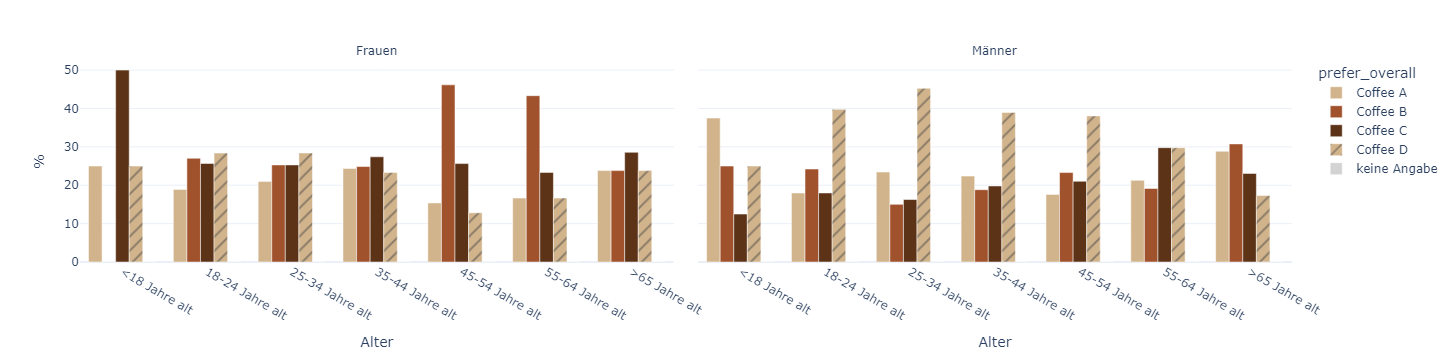

In [13]:
# Plot
fig = px.bar(df_cat, y="proportion", x="age", color="prefer_overall", 
             facet_col="gender",
                 pattern_shape="prefer_overall",
                 color_discrete_map=c_map,
                 pattern_shape_map=p_map,
                 template="plotly_white",
                 barmode="group",
                 category_orders={"prefer_overall": coffee_order})
for annotation in fig.layout.annotations:
    if "gender=männlich" in annotation.text:
        annotation.text = "Männer"
    elif "gender=weiblich" in annotation.text:
        annotation.text = "Frauen"
fig.update_layout(xaxis_title="Alter", yaxis_title="%")
fig.update_xaxes(title_text="Alter", row=1, col=2)

## Zusammenhang Kaffeegewohnheiten und Kaffeepräferenz

In [14]:
df_clean["expertise"]
df_cat = pd.DataFrame(df_clean.groupby(by="expertise", observed=False)["prefer_overall"].value_counts(normalize=True)).reset_index()
df_cat

,expertise,prefer_overall,proportion
0,1.0,Coffee B,0.333333
1,1.0,Coffee D,0.250000
2,1.0,Coffee A,0.208333
3,1.0,Coffee C,0.208333
4,2.0,Coffee B,0.378049
5,2.0,Coffee D,0.304878
6,2.0,Coffee C,0.195122
7,2.0,Coffee A,0.121951
8,3.0,Coffee B,0.326923
9,3.0,Coffee C,0.288462


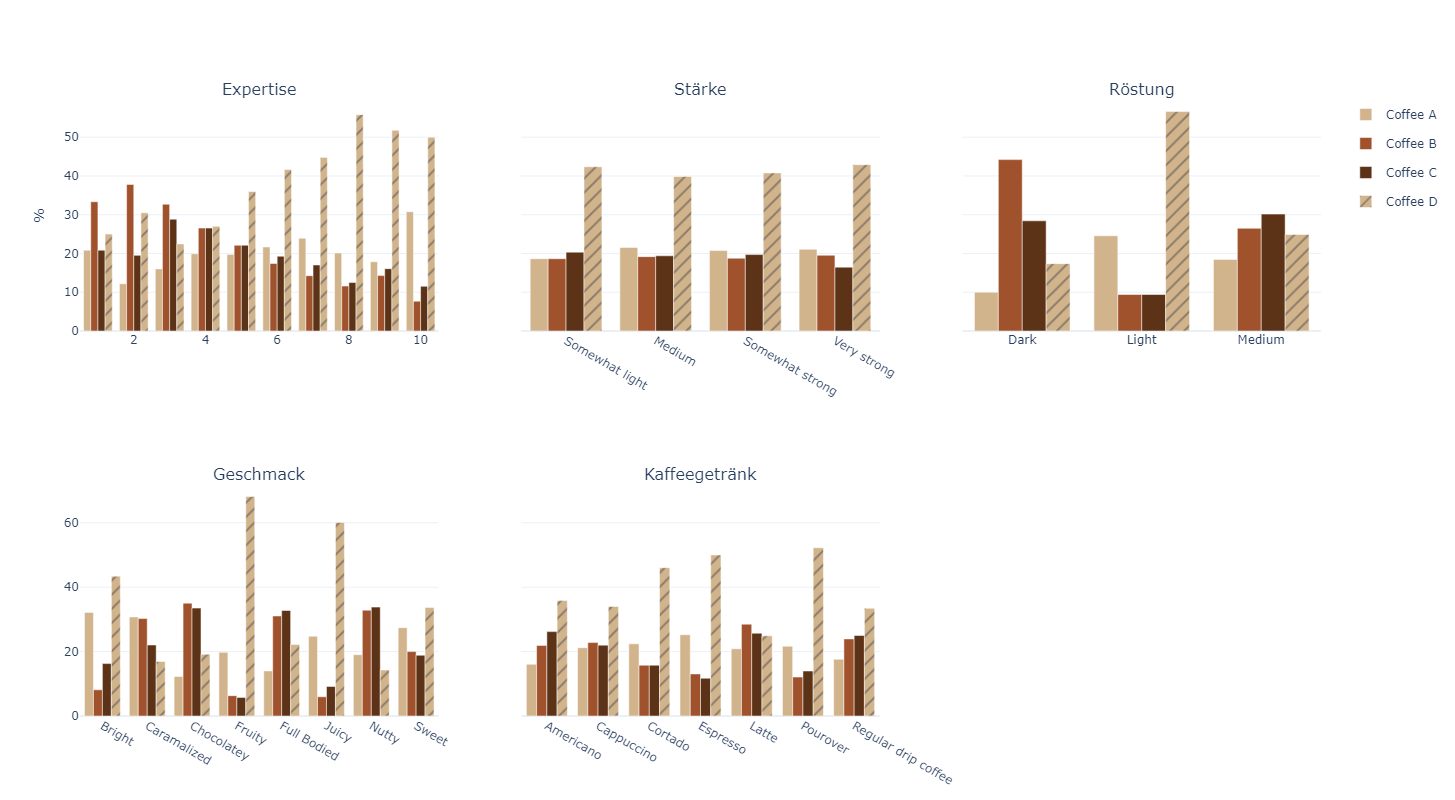

In [15]:
cols = ["expertise", "strength", "roast_level", "style", "favorite"]

fig = make_subplots(
    rows=2, cols=3,
    shared_yaxes=True,
    subplot_titles=["Expertise", "Stärke", "Röstung", "Geschmack", "Kaffeegetränk"]
)

for i, col in enumerate(cols):

    r = i // 3 + 1
    c = i % 3 + 1

    # Werte zählen für Plot
    df_cat = pd.DataFrame(df_clean.groupby(by=col, observed=False)["prefer_overall"].value_counts(normalize=True)).reset_index()
    df_cat["proportion"] = df_cat["proportion"]*100
    df_cat = df_cat[df_cat[col] != "keine Angabe"]
    p = px.bar(df_cat, y="proportion", x=col, color="prefer_overall", 
             pattern_shape="prefer_overall",
             color_discrete_map=c_map,
             pattern_shape_map=p_map,
             template="plotly_white",
             barmode="group",
             category_orders={"prefer_overall": coffee_order})

    for trace in p.data:
        trace.showlegend = (i == 0)
        fig.add_trace(trace, row=r, col=c)
        
fig.update_layout(xaxis_title="", yaxis_title="%",
                 height = 800, width = 1400, template = "plotly_white")
    

Je mehr sich jemand mit Kaffee auskennt, desto beliebter ist Kaffee D, bei niedriger Expertise ist Kaffee B am beliebtesten. Die Stärke des Kaffees scheint keinen großen Einfluss zu haben. Der bevorzugte Röstgrad beeinflusst die Wahl des Kaffees sehr stark. Bei Vorliebe für dunkle Röstungen ist Kaffee B die erste Wahl, gefolgt von C. Das kehrt sich bei Vorliebe für mittleren Röstgrad um. Und leichte Röstung ist am ehesten bei Kaffee D, gefolgt von A zu finden. Ebenso hat der bevorzugte "Style" und das bevorzugte Kaffeegetränk einen Einfluss.        

Zusammenfassend scheinen hier vor allem Expertise, den Ursprung des Kaffees zu kennen, der Röstgrad, Geschmacksrichtung, und Kaffeegetränk relevant für die Bestimmung der bevorzugten Kaffeesorte zu sein. 

### Zubereitungsart

In [18]:
# Daten von Zubereitungsart vorbereiten
brew = df.columns[df.columns.str.startswith('brew ')] 

df_brew = df[["submission_id", "prefer_overall"] + list(brew)].copy()
df_brew

,submission_id,prefer_overall,brew Bean-to-cup machine,brew Coffee brewing machine (e.g. Mr. Coffee),brew Coffee extract (e.g. Cometeer),brew Cold brew,brew Espresso,brew French press,brew Instant coffee,brew Other,brew Pod/capsule machine (e.g. Keurig/Nespresso),brew Pour over,brew keine Angabe
0,0E11K6,Coffee A,False,True,False,False,False,False,False,False,False,False,False
1,0E1D5Z,Coffee D,False,False,False,False,False,False,False,False,False,True,False
2,0E1qKB,Coffee D,False,False,False,False,False,False,False,False,False,True,False
3,0E1vgN,Coffee C,False,False,False,False,False,False,False,False,True,False,False
4,0EAKN6,Coffee A,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,zKWjd1,Coffee A,False,False,False,False,True,False,True,False,False,False,False
4038,zKWjyE,Coffee D,False,False,False,False,False,False,False,False,False,True,False
4039,zKWxaE,Coffee B,False,False,False,False,True,False,False,False,False,True,False
4040,zKWy91,Coffee C,False,False,False,False,False,False,False,True,False,True,False


In [26]:
df_cat = df_brew.groupby("prefer_overall")[list(brew) + ["brew keine Angabe"]].sum().reset_index()


# long format
df_cat_long = df_cat.melt(
    id_vars="prefer_overall",
    var_name="Zubereitung",
    value_name="Anzahl"
)

# "brew " aus Spaltennamen entfernen
df_cat_long["Zubereitung"] = df_cat_long["Zubereitung"].str.replace("brew ", "", regex=False)
df_cat_long = df_cat_long[df_cat_long["Zubereitung"] != "keine Angabe"]
df_cat_long['Prozent'] = df_cat_long.groupby('prefer_overall')['Anzahl'].transform(lambda x: 100 * x / x.sum())
df_cat_long

C:\Users\alfa\AppData\Local\Temp\ipykernel_4720\1853042886.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\alfa\AppData\Local\Temp\ipykernel_4720\1853042886.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,prefer_overall,Zubereitung,Anzahl,Prozent
0,Coffee A,Bean-to-cup machine,19,1.319444
1,Coffee B,Bean-to-cup machine,19,1.414743
2,Coffee C,Bean-to-cup machine,22,1.647940
3,Coffee D,Bean-to-cup machine,19,0.711078
4,keine Angabe,Bean-to-cup machine,5,1.392758
5,Coffee A,Coffee brewing machine (e.g. Mr. Coffee),129,8.958333
6,Coffee B,Coffee brewing machine (e.g. Mr. Coffee),150,11.169025
7,Coffee C,Coffee brewing machine (e.g. Mr. Coffee),189,14.157303
8,Coffee D,Coffee brewing machine (e.g. Mr. Coffee),170,6.362275
9,keine Angabe,Coffee brewing machine (e.g. Mr. Coffee),25,6.963788


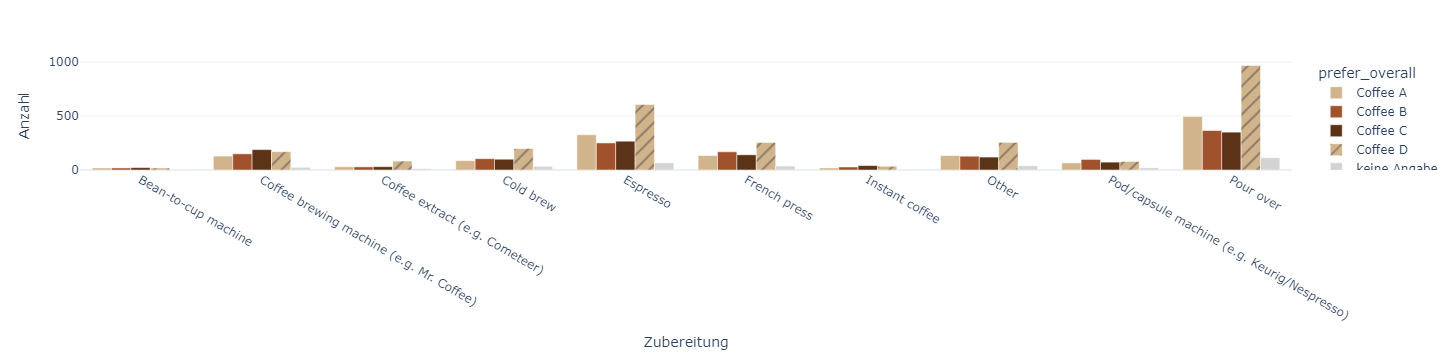

In [28]:
# Plot

fig = px.bar(df_cat_long, y="Anzahl", x="Zubereitung", color="prefer_overall", 
             pattern_shape="prefer_overall",
             color_discrete_map=c_map,
             pattern_shape_map=p_map,
             template="plotly_white",
             barmode="group",
             category_orders={"prefer_overall": coffee_order})
fig.update_layout(xaxis_title="Zubereitung", yaxis_title="Anzahl")

## Dashboard Kaffeeempfehlung

Da die Gruppe sich zunehmend verkleinert, je mehr Variablen zur Auswahl zur Verfügung stehen und damit die Aussagekraft fragwürdig wird,
muss eine Auswahl der Variablen, die einen Einfluss auf die bevorzugte Kaffeesorte haben stattfinden. Einen großen Einfluss scheinen Alter, 
Geschlecht, Expertise, Röstgrad und Geschmacksrichtung zu haben. Bevorzugtes Kaffeegetränk hat einen vergleichsweise geringen Einfluss und ist deswegen
der einfachheithalber nicht im Dashboard enthalten. Trotzdem ist je nach Auswahl der verbleibende Datensatz sehr klein, sodass für ein aussagekräftiges
Tool noch weitere Daten erhoben werden sollten.

In [ ]:
# App initialisieren 
app = Dash()

app.layout = html.Div([
    html.Div(className='row', children='Kaffeeempfehlung',
             style={'textAlign': 'center', 'fontSize': 30}),
    html.Hr(),

    html.Div(style={'display': 'flex', 'justifyContent': 'space-between'}, children=[
        html.Div([
            html.Label("Alter", style={'marginTop': '10px'}),
            dcc.Dropdown(id="age-dropdown", options=[{'label': a, 'value': a} for a in df_clean['age'].unique() if a != 'keine Angabe'] + [{'label': 'Alle', 'value': 'all'}],
                         value='all',
                        style={'marginBottom': '20px'}),

            html.Label("Geschlecht", style={'marginTop': '10px'}),
            dcc.Dropdown(id="gender-dropdown", options=[{'label': g, 'value': g} for g in df_clean['gender'].unique() if g != 'keine Angabe'] + [{'label': 'Alle', 'value': 'all'}],
                         value='all',
                        style={'marginBottom': '20px'}),

            html.Label("Bevorzugte Röstung", style={'marginTop': '10px'}),
            dcc.Dropdown(id="roast-dropdown", options=[{'label': r, 'value': r} for r in df_clean['roast_level'].unique() if r != 'keine Angabe'] + [{'label': 'Alle', 'value': 'all'}],
                         value='all',
                        style={'marginBottom': '20px'}),
            
            html.Label("Bevorzugter Geschmack", style={'marginTop': '10px'}),
            dcc.Dropdown(id="taste-dropdown", options=[{'label': t, 'value': t} for t in df_clean['style'].unique() if r != 'keine Angabe'] + [{'label': 'Alle', 'value': 'all'}],
                         value='all',
                        style={'marginBottom': '20px'}),
            
            html.Label("Expertise", style={'marginTop': '20px'}),
            dcc.RangeSlider(
                id='expertise-slider',
                min=df_clean['expertise'].min(),
                max=df_clean['expertise'].max(),
                step=1,
                value=[df_clean['expertise'].min(), df_clean['expertise'].max()],
                marks={i: str(i) for i in sorted(df_clean['expertise'].unique())},
                tooltip={"placement": "bottom", "always_visible": True}
            ),
        ], style={'width': '45%'}),

        html.Div([
            html.Div(id='summary-text', style={'fontSize': 18, 'marginBottom': 10}),
            dcc.Graph(id='pie-plot')
        ], style={'width': '50%', 'paddingLeft': '20px'})
    ])
])


@app.callback(
    Output('pie-plot', 'figure'),
    Output('summary-text', 'children'),
    Input('age-dropdown', 'value'),
    Input('gender-dropdown', 'value'),
    Input('roast-dropdown', 'value'),
    Input('taste-dropdown', 'value'),
    Input('expertise-slider', 'value')
)
def update_pie(age_val, gender_val, roast_val, taste_val, expertise_val):
    # Filter anwenden
    df_filtered = df_clean.copy()
    if age_val != 'all':
        df_filtered = df_filtered[df_filtered['age'] == age_val]
    if gender_val != 'all':
        df_filtered = df_filtered[df_filtered['gender'] == gender_val]
    if roast_val != 'all':
        df_filtered = df_filtered[df_filtered['roast_level'] == roast_val]
    if taste_val != 'all':
        df_filtered = df_filtered[df_filtered['style'] == taste_val]
    if expertise_val:
        df_filtered = df_filtered[
            (df_filtered['expertise'] >= expertise_val[0]) & 
            (df_filtered['expertise'] <= expertise_val[1])
        ]

    if df_filtered.empty:
        raise PreventUpdate

    # Anteile berechnen
    df_counts = df_filtered['prefer_overall'].value_counts(normalize=True).reset_index()
    df_counts.columns = ['coffee', 'percent']
    df_counts['percent'] *= 100

    # Top-Kaffee
    top_row = df_counts.iloc[0]
    top_coffee = top_row['coffee']
    top_percent = round(top_row['percent'], 1)

    # Farben und Muster
    colors = {
        "Coffee A": "#d2b48c",
        "Coffee D": "#e6c8a4",
        "Coffee B": "#a0522d",
        "Coffee C": "#5c3317",
        "keine Angabe": "#d3d3d3"
    }
    patterns = {
        "Coffee D": "/"
    }

    # Pie-Plot
    fig = px.pie(df_counts,
                 names='coffee',
                 values='percent',
                 color='coffee',
                 color_discrete_map=colors,
                 hole=0.4)

    # Slice hervorheben
    pull_values = [0.1 if c == top_coffee else 0 for c in df_counts['coffee']]
    fig.update_traces(pull=pull_values)

    fig.update_traces(marker=dict(
        pattern=dict(shape=[patterns.get(c, "") for c in df_counts['coffee']])
    ))

    fig.update_layout(
        showlegend=True,
        template="plotly_white",
        margin=dict(t=20, b=20, l=0, r=0)
    )

    # Dynamischer Text
    text = f"Von {len(df_filtered)} Personen mit diesen Präferenzen und Eigenschaften bevorzugten {top_percent:.1f}% {top_coffee}"

    return fig, text

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8052)
